---

# **Predicción de Precios de Laptops**

Este notebook implementa un pipeline completo de Machine Learning para predecir los precios de laptops utilizando diferentes 
algoritmos de regresión.

Ademas es una continuacion de un estudio estadistíco hecho sobre este mismo dataset y que se encuentra en https://github.com/gaboCiber/A-statistical-analisis-of-Laptop-Prices.git

---

### Importación de Librerías

Se importan todas las librerías necesarias para el análisis de datos, preprocesamiento, entrenamiento de modelos y evaluación:

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import numpy as np

import scipy.stats as stats
from scipy.stats import ttest_rel, f_oneway, shapiro, wilcoxon
from scipy.stats import shapiro

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from typing import List

### Carga de Datos

Se carga el dataset `laptop_prices.csv` que contiene información técnica de laptops y sus precios en euros.

In [32]:
laptop_data = pd.read_csv('laptop_prices.csv')
laptop_data.head()

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,...,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


---
---

## 1. Analisis Exploratorio de Datos

**Refierase para mas detalles a https://github.com/gaboCiber/A-statistical-analisis-of-Laptop-Prices/blob/master/Presentacion%20de%20Estadistica.%20Precio%20de%20las%20Laptops.pdf**


### 1.1 Información del Dataset

Se utiliza `.info()` para obtener información detallada sobre las columnas, tipos de datos y valores nulos. Esto ayuda a identificar posibles problemas de calidad de datos.

In [33]:
laptop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1275 non-null   object 
 1   Product               1275 non-null   object 
 2   TypeName              1275 non-null   object 
 3   Inches                1275 non-null   float64
 4   Ram                   1275 non-null   int64  
 5   OS                    1275 non-null   object 
 6   Weight                1275 non-null   float64
 7   Price_euros           1275 non-null   float64
 8   Screen                1275 non-null   object 
 9   ScreenW               1275 non-null   int64  
 10  ScreenH               1275 non-null   int64  
 11  Touchscreen           1275 non-null   object 
 12  IPSpanel              1275 non-null   object 
 13  RetinaDisplay         1275 non-null   object 
 14  CPU_company           1275 non-null   object 
 15  CPU_freq             

Y entonces se puede apreciar que existen varias variables numerícas como categóricas. Asi como que no existen valores nulos en el dataset

### 1.2 Análisis de Features Numericos

Se calculan estadísticas descriptivas para las variables numéricas (media, desviación estándar, cuartiles, etc.) para entender la distribución de los datos.

In [34]:
laptop_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Inches,1275.0,15.022902,1.429470,10.10,14.0,15.60,15.60,18.4
Ram,1275.0,8.440784,5.097809,2.00,4.0,8.00,8.00,64.0
Weight,1275.0,2.040525,0.669196,0.69,1.5,2.04,2.31,4.7
Price_euros,1275.0,1134.969059,700.752504,174.00,609.0,989.00,1496.50,6099.0
ScreenW,1275.0,1900.043922,493.346186,1366.00,1920.0,1920.00,1920.00,3840.0
ScreenH,1275.0,1073.904314,283.883940,768.00,1080.0,1080.00,1080.00,2160.0
CPU_freq,1275.0,2.302980,0.503846,0.90,2.0,2.50,2.70,3.6
PrimaryStorage,1275.0,444.517647,365.537726,8.00,256.0,256.00,512.00,2048.0
SecondaryStorage,1275.0,176.069020,415.960655,0.00,0.0,0.00,0.00,2048.0


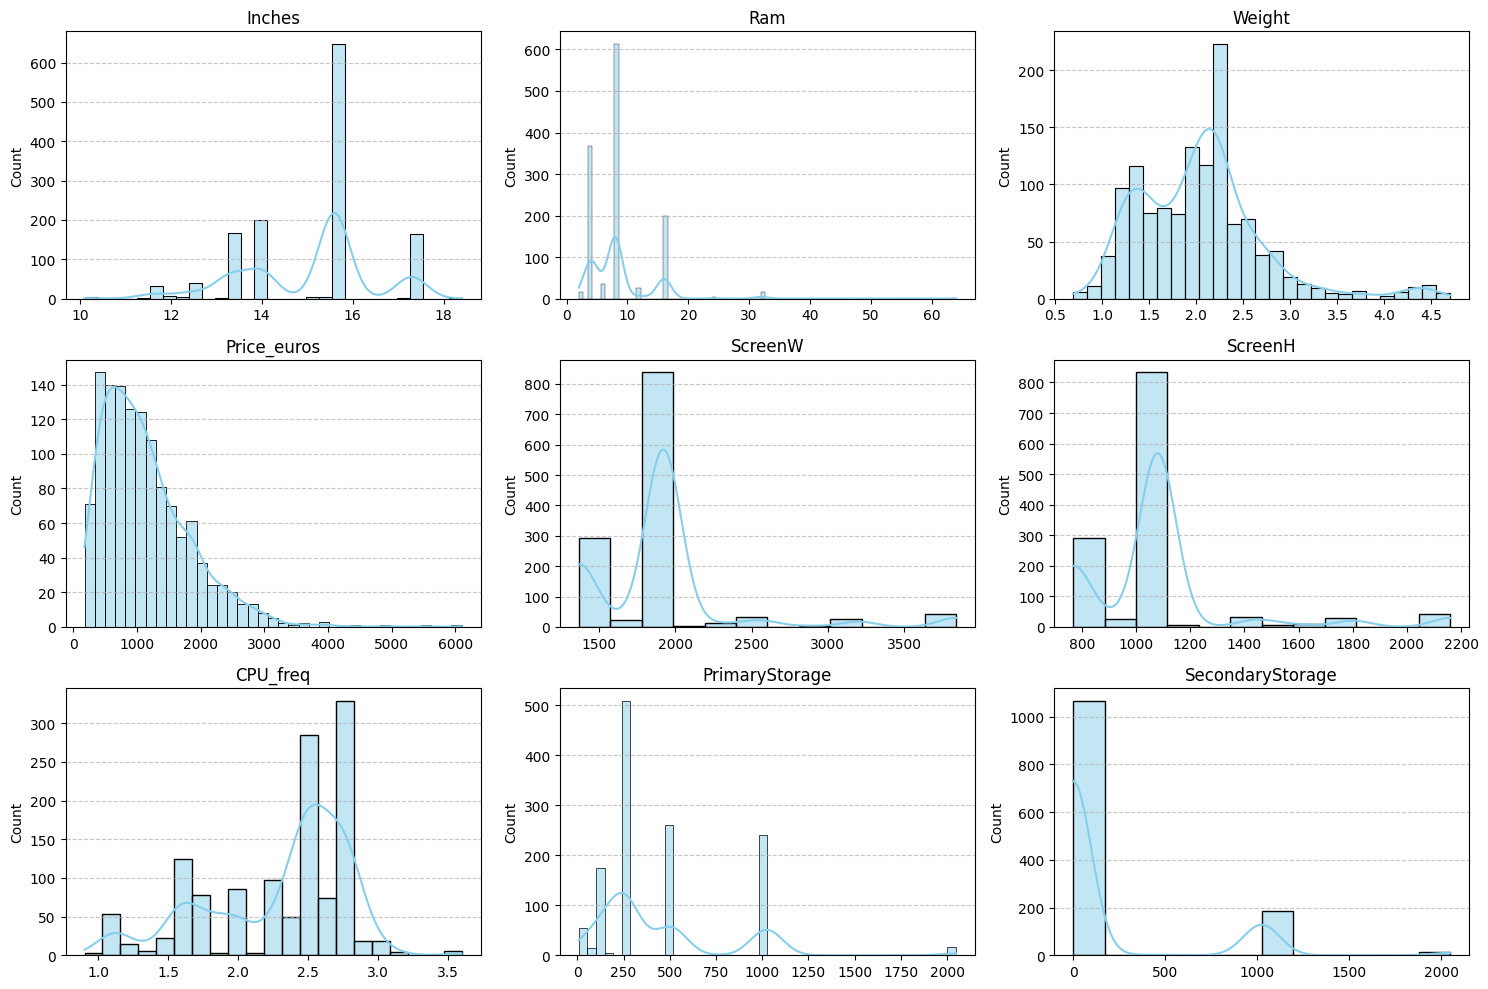

In [35]:
# Crear boxplots para cada columna numérica
numerical_columns = laptop_data.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=laptop_data, x=col, color='skyblue', kde=True)
    plt.title(f'{col}', fontsize=12)
    plt.xlabel('')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Conclusiones del Análisis**

Las laptops están diseñadas predominantemente para usuarios promedio con especificaciones que equilibran funcionalidad y costo:
- Pantallas 13-15 pulgadas Full HD
- 8 GB RAM estándar
- SSD de 256-512 GB
- Pesos entre 1-2 kg para portabilidad
- ScreenW/ScreenH: Resolución predominante 1920x1080 (Full HD)

El análisis revela un mercado maduro con configuraciones estandarizadas para el usuario general, pero con segmentos bien definidos para necesidades especializadas.

### 1.3 Análisis de Features Categóricos

Se cuenta la cantidad de valores únicos en cada variable categórica para entender la cardinalidad y complejidad de las características.

In [36]:
laptop_data.select_dtypes(include='object').nunique().to_frame(name='Unique Values')

,Unique Values
Company,19
Product,618
TypeName,6
OS,9
Screen,4
Touchscreen,2
IPSpanel,2
RetinaDisplay,2
CPU_company,3
CPU_model,93


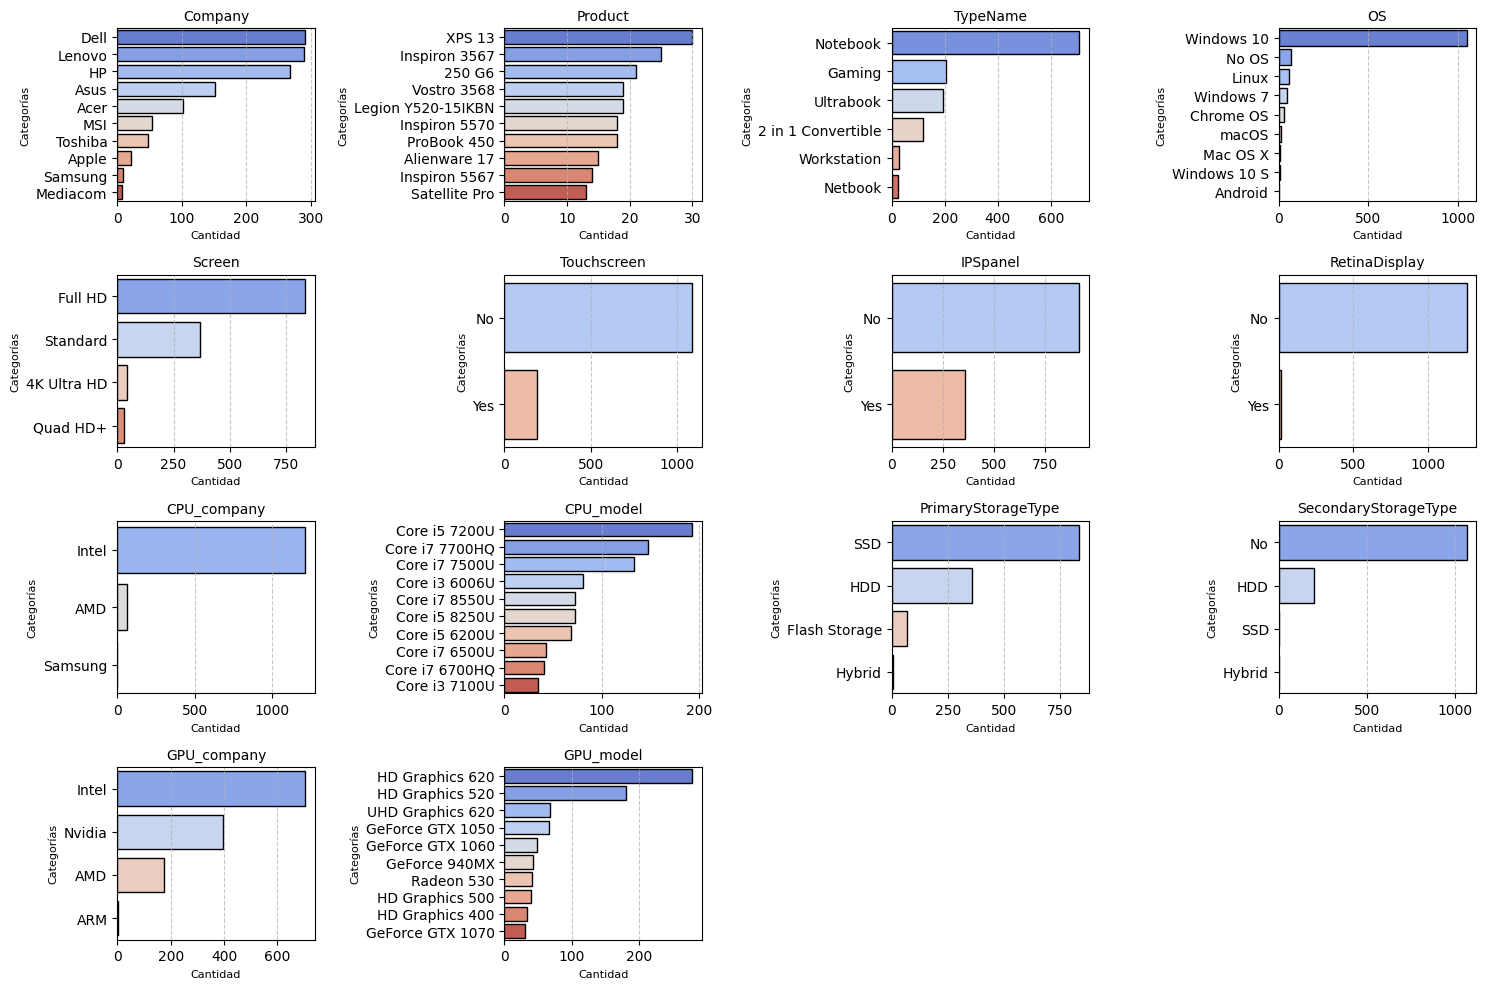

In [37]:
# Graficar los valores únicos de las columnas categóricas
categorical_columns = laptop_data.select_dtypes(include='object').columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(4, 4, i)
    unique_counts = laptop_data[col].value_counts().head(10)  # Top 10 categorías
    sns.barplot(
        y=unique_counts.index, 
        x=unique_counts.values, 
        palette='coolwarm', 
        edgecolor='black', 
        hue=unique_counts.index, 
        dodge=False 
    )
    plt.title(col, fontsize=10)
    plt.xlabel('Cantidad', fontsize=8)
    plt.ylabel('Categorías', fontsize=8)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Conclusión del Análisis**

El mercado de laptops se caracteriza por una estructura oligopólica con dominancia clara de marcas principales (HP, Dell, Lenovo) y tecnología predominante (Intel, Windows, SSD). Existe una segmentación bien definida entre dispositivos estándar para usuarios promedio y equipos especializados para gaming, trabajo profesional y usuarios premium. La tendencia actual se orienta hacia dispositivos portátiles versátiles (Notebook/Ultrabook) con especificaciones estandarizadas que equilibran costo y funcionalidad.

### 1.4 Análisis del feauture objetivo: **Price_euros**

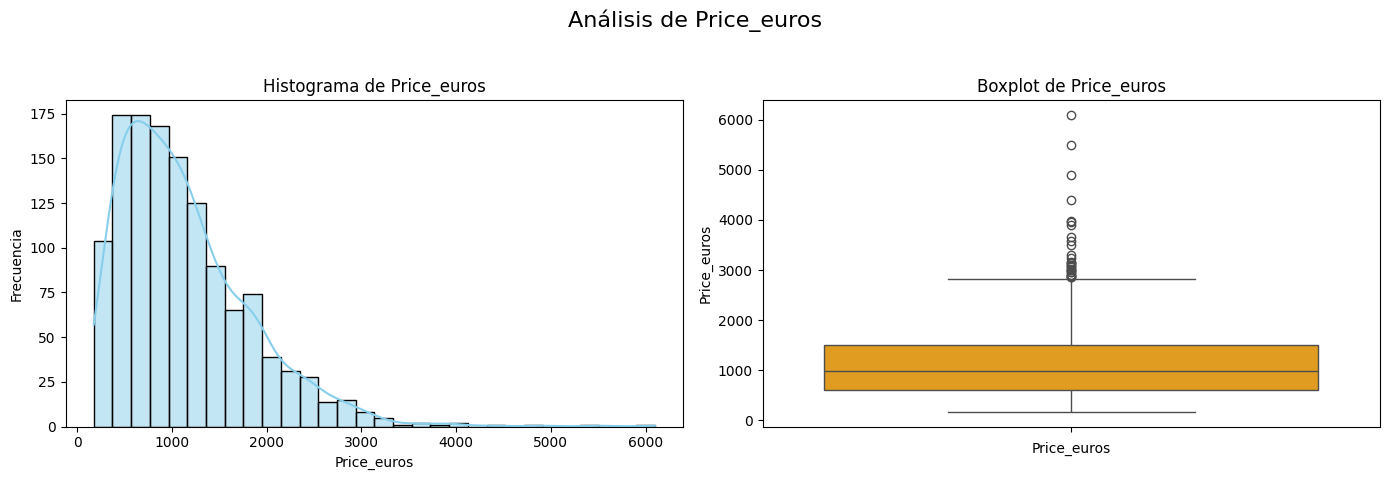

In [38]:
def plot_histogram_and_boxplot(data, columns):
    """
    Genera un histograma y un boxplot para cada columna dada.

    Args:
    data (DataFrame): Dataset que contiene las columnas.
    columns (list): Lista de nombres de columnas a graficar.
    """
    for column in columns:
        if column not in data.columns:
            print(f"La columna '{column}' no existe en el dataset.")
            continue
        
        # Crear una figura con dos subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f'Análisis de {column}', fontsize=16)
        
        # Histograma
        sns.histplot(data[column], bins=30, kde=True, ax=axes[0], color="skyblue")
        axes[0].set_title(f'Histograma de {column}')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Frecuencia')
        
        # Boxplot
        sns.boxplot(data[column], ax=axes[1], color="orange")
        axes[1].set_title(f'Boxplot de {column}')
        axes[1].set_xlabel(column)
        
        # Mostrar los gráficos
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta para no sobreponer el título
        plt.show()


plot_histogram_and_boxplot(laptop_data, ['Price_euros'])

**Distribución de `prices_euros`**

Según el histograma de la columna `prices_euros`, parece que esta variable no sigue una distribución normal debido a su asimetría positiva (sesgo hacia la derecha). Sin embargo, con base en su forma, podría seguir una distribución Log-Normal.El histograma muestra una acumulación en los precios bajos (500-1500 euros) y una cola hacia precios más altos, lo cual es típico de esta distribución.


<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_31020/3273927473.py:24: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, pdf, 'r-', label=f'Normal Fit ($\mu={mu:.2f}, \sigma={sigma:.2f}$)')
/tmp/ipykernel_31020/3273927473.py:24: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, pdf, 'r-', label=f'Normal Fit ($\mu={mu:.2f}, \sigma={sigma:.2f}$)')


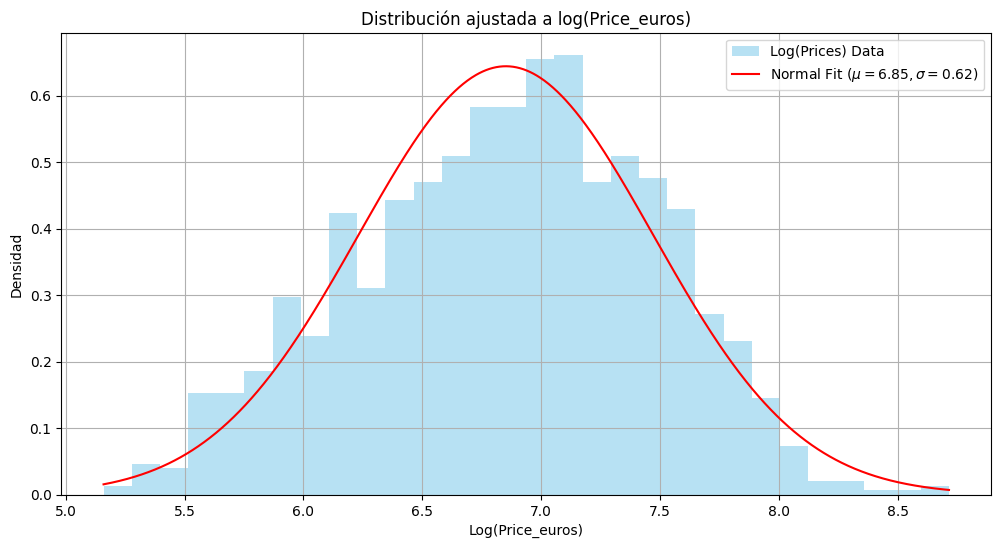

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Filtrar valores de Price_euros
price_data = laptop_data['Price_euros'].dropna()

# Aplicar logaritmo natural para modelar como distribución log-normal
log_prices = np.log(price_data)

# Ajustar una distribución normal a los datos transformados
#mu, sigma = stats.norm.fit(log_prices)
mu = np.mean(log_prices)  # Estimador de la Media
sigma = np.sqrt(np.mean((log_prices - mu)**2))  # Estimador de la desviación estándar

# Graficar el ajuste
plt.figure(figsize=(12, 6))

# Histograma de los datos transformados
plt.hist(log_prices, bins=30, density=True, alpha=0.6, color='skyblue', label='Log(Prices) Data')

# Distribución ajustada
x = np.linspace(log_prices.min(), log_prices.max(), 1000)
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r-', label=f'Normal Fit ($\mu={mu:.2f}, \sigma={sigma:.2f}$)')

plt.title("Distribución ajustada a log(Price_euros)")
plt.xlabel("Log(Price_euros)")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True)
plt.show()


**Conclusiones de la distribución Log-Normal de `Price_euros` según el el análisis gráfico**

Con base en el ajuste realizado, los datos transformados mediante el logaritmo natural (`log(Price_euros)`) **parecen** seguir una distribución normal razonablemente bien, pero no es perfecta. Si fuera cierto, esto implica que los precios originales (`Price_euros`) se ajustan a una distribución log-normal.

Una distribución log-normal significa que los precios bajos son más frecuentes, mientras que los precios altos ocurren con menor frecuencia pero tienen un impacto significativo.

Este comportamiento es común en mercados donde los valores extremos (como laptops premium) tienen gran importancia en comparación con productos regulares.


### 1.5 Analisis de la linealidad de las variables

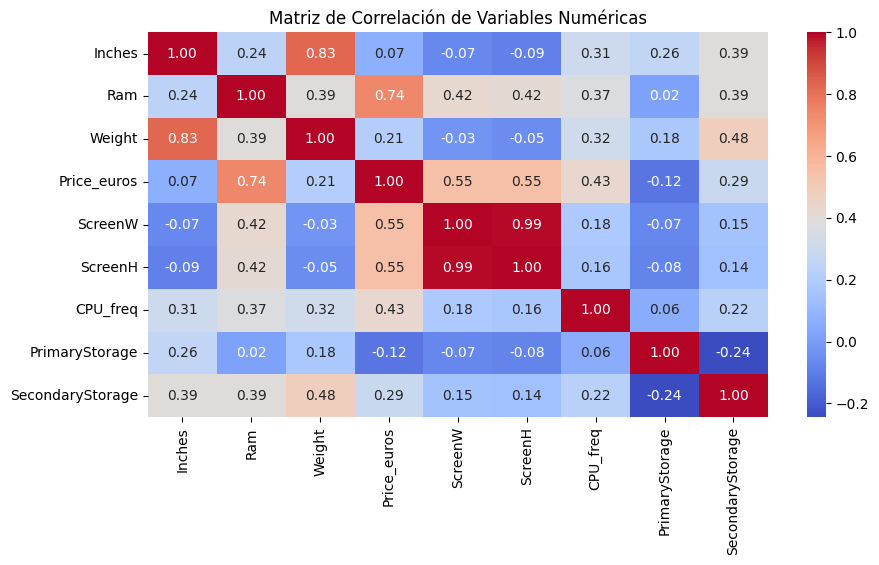

In [40]:
# Seleccionar solo columnas numéricas
numerical_columns = laptop_data.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
correlation_matrix = numerical_columns.corr()

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()

**Resumen - Análisis de Correlación**

**Correlaciones Fuertes**
- **ScreenW ↔ ScreenH (r ≈ 0.99)**: Relación casi perfecta entre dimensiones de pantalla
- **Inches ↔ Weight (r ≈ 0.83)**: Pantallas más grandes implican mayor peso

**Correlaciones Moderadas con Precio**
- **Price_euros ↔ Ram (r ≈ 0.68)**: Mayor RAM = mayor precio
- **Price_euros ↔ ScreenW/ScreenH (r ≈ 0.55)**: Pantallas más grandes = más caras
- **Price_euros ↔ CPU_freq (r ≈ 0.50)**: Procesadores más rápidos = más costosos

**Correlaciones Bajas/Insignificantes**
- **Price_euros ↔ Inches (r ≈ 0.04)**: Tamaño de pantalla no determina precio
- **PrimaryStorage ↔ Price_euros (r ≈ -0.15)**: Almacenamiento no influye significativamente en costo

**Otras Relaciones Relevantes**
- **SecondaryStorage ↔ Weight (r ≈ 0.48)**: Más almacenamiento secundario = más peso
- **Ram ↔ ScreenW/ScreenH (r ≈ 0.42)**: Pantallas grandes suelen tener más RAM

**Conclusión Principal**
El precio está más influenciado por **características de rendimiento** (RAM, CPU_freq) que por **características físicas** (tamaño, peso). Las dimensiones de pantalla y peso están fuertemente relacionadas entre sí, mientras que el almacenamiento tiene poco impacto en el precio final.

---
---

## 2. Entrenamiento y análisis de los modelos de predicción

### 2.1 Codificación de Variables Categóricas

Se utiliza `LabelEncoder` para convertir todas las variables categóricas a valores numéricos. Esto es necesario ya que los modelos de Machine Learning solo trabajan con datos numéricos.

In [41]:
def encode_features(df: pd.DataFrame, features: List[str]):
    for feat in features:
        le = LabelEncoder()
        df[feat] = le.fit_transform(df[feat])
        
categorical_columns = laptop_data.select_dtypes(include=['object']).columns.tolist()

encode_features(laptop_data, categorical_columns)
laptop_data.head()

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,1,300,4,13.3,8,8,1.37,1339.69,3,2560,...,1,1,2.3,40,128,0,3,2,2,60
1,1,301,4,13.3,8,8,1.34,898.94,3,1440,...,0,1,1.8,40,128,0,0,2,2,53
2,7,50,3,15.6,8,4,1.86,575.00,1,1920,...,0,1,2.5,46,256,0,3,2,2,55
3,1,300,4,15.4,16,8,1.83,2537.45,3,2880,...,1,1,2.7,54,512,0,3,2,0,80
4,1,300,4,13.3,8,8,1.37,1803.60,3,2560,...,1,1,3.1,40,256,0,3,2,2,61


### 2.2 Verificación de Valores Faltantes


In [42]:
# Verificar valores faltantes
print("=== Valores faltantes por columna ===")
missing_values = laptop_data.isnull().sum()

print(missing_values[missing_values > 0])


=== Valores faltantes por columna ===
Series([], dtype: int64)


### 2.3 División de Datos

Se divide el dataset en tres conjuntos:
- **Entrenamiento (70%)**: Para entrenar los modelos
- **Validación (20%)**: Para ajustar hiperparámetros
- **Prueba (10%)**: Para evaluación final del modelo

Se mantiene `Price_euros` como variable objetivo (y) y el resto como características (X).

In [43]:
X = laptop_data.drop('Price_euros', axis=1)
y = laptop_data["Price_euros"]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.9, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=42)

print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de validación: {X_val.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")
print(f"\nTotal: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} muestras")

Conjunto de entrenamiento: 917 muestras
Conjunto de validación: 230 muestras
Conjunto de prueba: 128 muestras

Total: 1275 muestras


### 2.4 Funciones de Evaluación y Entrenamiento

Se definen dos funciones clave:

1. **`evaluate()`**: Calcula múltiples métricas de evaluación:
   - MSE (Error Cuadrático Medio)
   - RMSE (Raíz del Error Cuadrático Medio)
   - R² (Coeficiente de Determinación)
   - MAE (Error Absoluto Medio)
   - MAPE (Error Porcentual Absoluto Medio)

2. **`train_val_model()`**: Entrena un modelo y lo evalúa en el conjunto de validación.

In [44]:
def evaluate(y_val, y_predict):
    # Evaluate (MSE R2)
    mse = mean_squared_error(y_val, y_predict)
    r2 = r2_score(y_val, y_predict)
    mae = mean_absolute_error(y_val, y_predict)
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    mape = mean_absolute_percentage_error(y_val, y_predict)  # Mean Absolute Percentage Error

    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")
    print()


def train_val_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_val)
    evaluate(y_val, y_predict)
    return model

### 2.5 Definición de Modelos

Se inicializan cuatro modelos de regresión diferentes:
- **Linear Regression**: Modelo lineal simple como baseline
- **Decision Tree**: Árbol de decisión con profundidad máxima de 10
- **Random Forest**: Ensemble de árboles con 100 estimadores
- **XGBoost**: Algoritmo de gradient boosting optimizado

Todos los modelos usan `random_state=42` para reproducibilidad.

In [45]:
ln = LinearRegression()
dt = DecisionTreeRegressor(random_state=42, max_depth=10)
rf = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
xg = XGBRegressor(random_state=42, max_depth=10)

models = [ln, dt, rf, xg]
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']

### 2.6 Entrenamiento y Evaluación Inicial

Se entrenan todos los modelos en el conjunto de entrenamiento y se evalúan en el conjunto de validación. 

In [46]:
train_models = []
for i, model in enumerate(models):
    print(model_names[i])
    train_models.append(train_val_model(model, X_train, y_train, X_val, y_val ))


Linear Regression
MSE: 108986.55
RMSE: 330.13
R2: 0.7181
MAE: 251.46
MAPE: 0.2894 (28.94%)

Decision Tree
MSE: 100343.50
RMSE: 316.77
R2: 0.7404
MAE: 200.23
MAPE: 0.2005 (20.05%)

Random Forest
MSE: 48576.92
RMSE: 220.40
R2: 0.8743
MAE: 155.55
MAPE: 0.1617 (16.17%)

XGBoost
MSE: 50550.43
RMSE: 224.83
R2: 0.8692
MAE: 155.20
MAPE: 0.1498 (14.98%)



Los resultados muestran que:

**1. Los "Pesos Pesados": Random Forest vs. XGBoost**

Hay un empate técnico muy interesante aquí, pero con matices:

* **XGBoost es el más "ajustado":** Tiene el **MAE** más bajo ($155.20) y el **MAPE** más bajo (14.9%). Esto significa que, en el día a día, sus predicciones están más cerca del precio real en términos porcentuales.
* **Random Forest es el más "estable":** Su **R²** es ligeramente superior (87.4%) y su **RMSE** es menor (220.40 vs 224.83). Esto indica que Random Forest comete menos "errores grandes" o catastróficos que XGBoost en este dataset específico.

**2. El salto de calidad**

Existe una diferencia abismal entre los modelos simples y los de ensamble. Al pasar de **Regresión Lineal** a **Random Forest**, se redujo el error promedio en casi **$100** por laptop y se aumentó la capacidad de explicación del modelo: de un 71% a un 87%.

**3. Análisis del MAPE (Error Porcentual)**

* Un **MAPE del 14.9% (XGBoost)** es un resultado bastante sólido para predicción de precios. Significa que si una laptop cuesta $1,000, el modelo suele estar en el rango de $850 - $1,150.
* La **Regresión Lineal**, con un 29% de error porcentual, es demasiado imprecisa para ser usada en un entorno real.


### 2.7 Validación Cruzada

Se realiza validación cruzada con 10 folds para obtener una evaluación más robusta de los modelos. Esto ayuda a:
- Reducir el sobreajuste
- Obtener estimaciones más estables del rendimiento
- Comparar modelos de manera más justa

Se usa MAE como métrica principal para la validación cruzada.

In [47]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

print("=== RESULTADOS VALIDACIÓN CRUZADA (10 folds) ===")
print()

cv_scores = []
for i, model in enumerate(models):
    
    cv_model_score = cross_val_score(model, X_train_val, y_train_val, cv=kfold, scoring='neg_mean_absolute_error')
    cv_scores.append(-cv_model_score)
    
    print(f"{model_names[i]} (MAE):")
    print(f"Mean CV Score: {-cv_model_score.mean()}")
    print(f"STD CV Score: {cv_model_score.std()}")
    print()


=== RESULTADOS VALIDACIÓN CRUZADA (10 folds) ===

Linear Regression (MAE):
Mean CV Score: 272.3518144565126
STD CV Score: 24.895038923919056

Decision Tree (MAE):
Mean CV Score: 228.12223023173274
STD CV Score: 19.642408885576963

Random Forest (MAE):
Mean CV Score: 182.24329388896484
STD CV Score: 19.15566804225172

XGBoost (MAE):
Mean CV Score: 179.64884210309364
STD CV Score: 13.41296044762996



**Analisis de los resultados**

Tras realizar una validación cruzada de 10 iteraciones, **XGBoost** demostró ser el modelo superior no solo por alcanzar el menor error absoluto medio ($179.65), sino por presentar la mayor estabilidad (menor desviación estándar), lo que garantiza predicciones más consistentes ante datos no vistos.

### 2.8 Curvas de Aprendizaje

Se generan curvas de aprendizaje para analizar el comportamiento de los modelos con diferentes tamaños de conjunto de entrenamiento. Esto permite identificar:

- **Sobreajuste**: Si el error de entrenamiento es mucho menor que el de validación
- **Subajuste**: Si ambos errores son altos
- **Convergencia**: Si el modelo necesita más datos para mejorar

Las curvas muestran el rendimiento en función del tamaño del conjunto de entrenamiento.

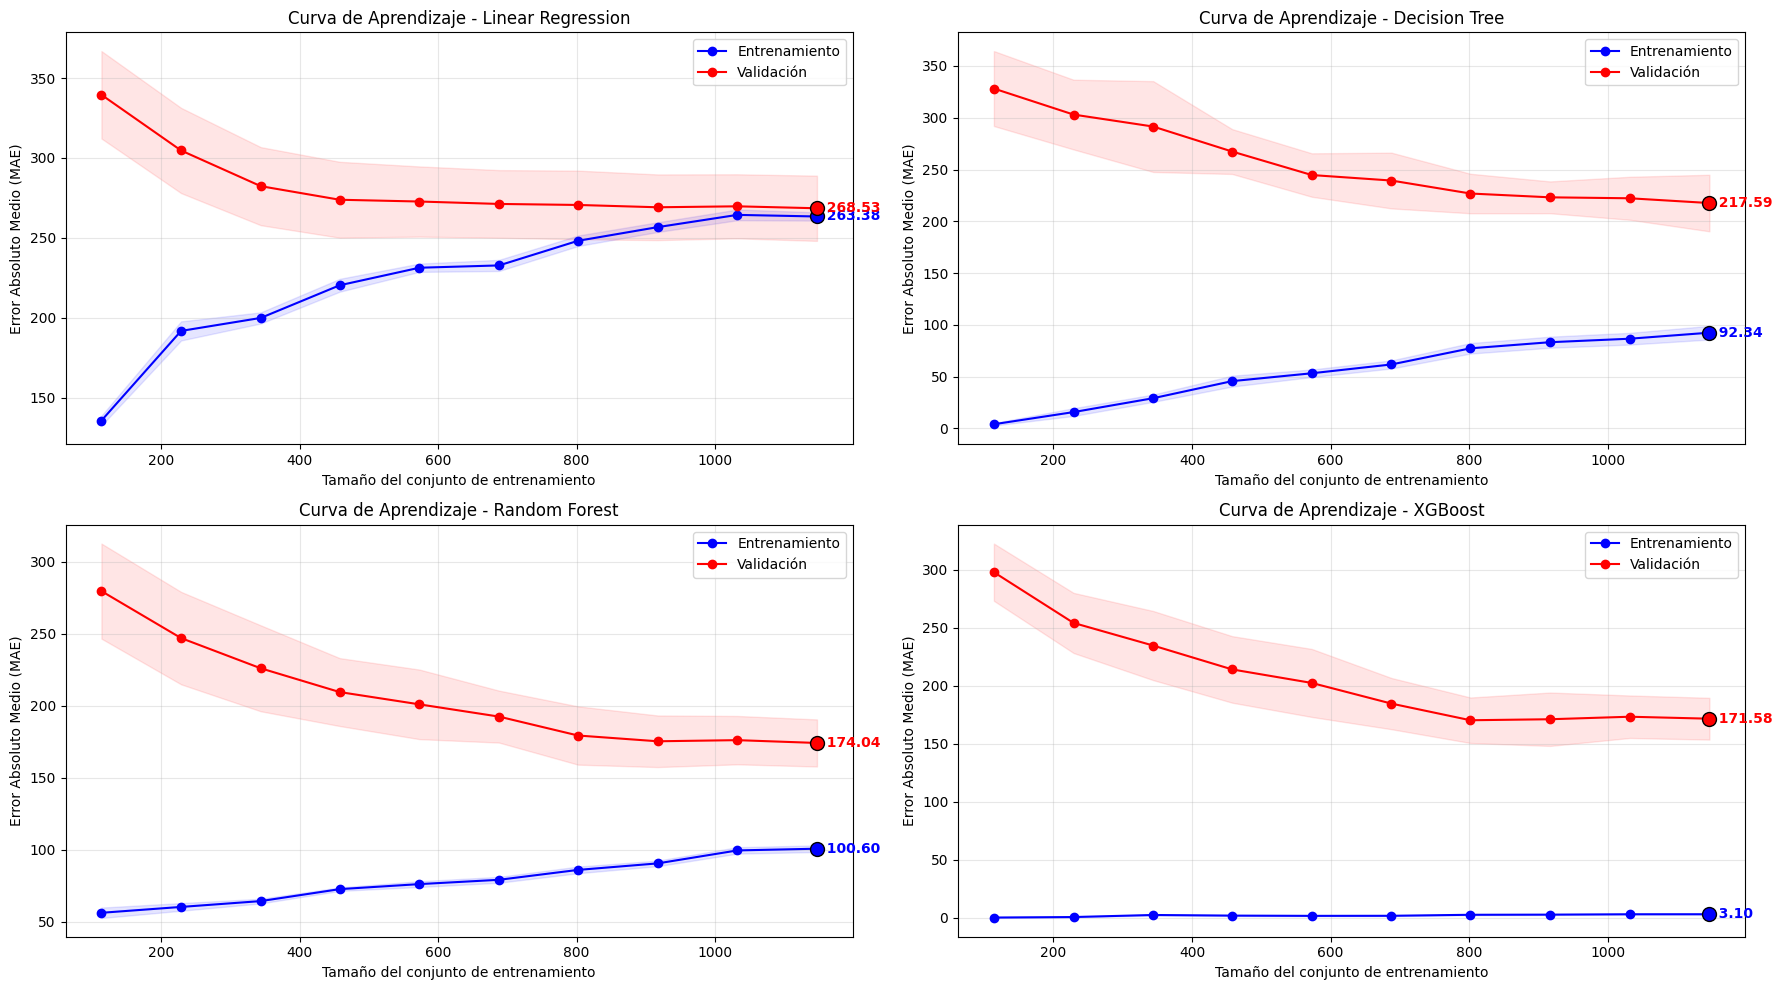

In [48]:
# Importar librerías para curvas de aprendizaje
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Función para graficar curvas de aprendizaje
def plot_learning_curve(estimator, X, y, title, ax=None):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=kfold, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_absolute_error',
        random_state=42
    )
    
    # Convertir a MSE positivo
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    val_scores_std = val_scores.std(axis=1)
    
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()
    
    # Graficar curvas principales
    ax.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Entrenamiento')
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color='blue')
    
    ax.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validación')
    ax.fill_between(train_sizes, val_scores_mean - val_scores_std,
                    val_scores_mean + val_scores_std, alpha=0.1, color='red')

    # Graficar y anotar el último punto ---
    last_size = train_sizes[-1]
    last_train = train_scores_mean[-1]
    last_val = val_scores_mean[-1]

    # Añadir etiquetas de texto en el último punto
    ax.text(last_size, last_train, f'  {last_train:.2f}', color='blue', fontweight='bold', va='center')
    ax.text(last_size, last_val, f'  {last_val:.2f}', color='red', fontweight='bold', va='center')
    
    # Opcional: un círculo más grande para resaltar el final
    ax.scatter(last_size, last_train, color='blue', s=100, edgecolors='black', zorder=5)
    ax.scatter(last_size, last_val, color='red', s=100, edgecolors='black', zorder=5)
    
    ax.set_xlabel('Tamaño del conjunto de entrenamiento')
    ax.set_ylabel('Error Absoluto Medio (MAE)')
    ax.set_title(f'Curva de Aprendizaje - {title}')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    return ax

# Crear curvas de aprendizaje para ambos modelos
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Linear Regression
plot_learning_curve(
    ln, 
    X, y, 
    'Linear Regression', 
    ax=axes[0][0]
)

# Decision Tree
plot_learning_curve(
    dt, 
    X, y, 
    'Decision Tree', 
    ax=axes[0][1]
)

# Random Forest
plot_learning_curve(
    rf, 
    X, y, 
    'Random Forest', 
    ax=axes[1][0]
)

# XGBoost
plot_learning_curve(
    xg, 
    X, y, 
    'XGBoost', 
    ax=axes[1][1]
)

plt.tight_layout()
plt.show()

**1. Linear Regression: El modelo de Alto Sesgo (Underfitting)**

* **Comportamiento:** Las dos curvas (entrenamiento y validación) convergen muy rápido y se quedan "pegadas" en un error alto (cerca de 265-268).
* **Diagnóstico:** **Underfitting**. El modelo es demasiado simple para capturar la complejidad de los precios de las laptops.
* **Conclusión:** Por más datos que le des, el error no va a bajar de ahí. La estructura lineal no es suficiente para este problema.

**2. Decision Tree: El modelo con Overfitting Crítico**

* **Comportamiento:** Hay una brecha (gap) gigante entre el error de entrenamiento (92.34) y el de validación (217.59).
* **Diagnóstico:** **Overfitting (Sobreajuste) alto**. El árbol está "memorizando" los datos de entrenamiento pero falla al generalizar.
* **Dato clave:** Nota que la curva de validación se ha aplanado por completo. Esto indica que añadir más datos no está ayudando a cerrar la brecha; el modelo necesita regularización (limitar la profundidad del árbol).

**3. Random Forest: Buen equilibrio, pero con potencial**

* **Comportamiento:** Las curvas muestran una tendencia descendente en validación (terminando en 174.04). La brecha con el entrenamiento (100.60) existe, pero es menor que en el árbol único.
* **Diagnóstico:** **Buen desempeño**, pero todavía hay un poco de varianza.
* **Dato clave:** La curva de validación todavía tiene una ligera pendiente hacia abajo al final. Esto sugiere que si con un dataset más grande, el error de validación podría seguir bajando un poco más.

**4. XGBoost: El ganador por Generalización**

* **Comportamiento:** Es el gráfico más revelador. El error de entrenamiento es prácticamente **cero (3.10)**, lo cual es normal en modelos de boosting que ajustan hasta el último residuo.
* **Diagnóstico:** Aunque la brecha es grande, XGBoost logra el **error de validación más bajo (171.58)**.
* **Análisis del Gap:** A diferencia del Decision Tree, aquí el error de validación es mucho menor. XGBoost "aprende" patrones mucho más finos que los otros modelos. La estabilidad de la curva de validación a partir de los 800 datos indica que el modelo ha extraído casi todo el conocimiento posible del dataset actual.


### 2.9 Importancia de Feautures

Se analiza la importancia de cada característica para los dos mejores modelos (Random Forest y XGBoost). Esto permite entender qué factores técnicos influyen más en el precio de las laptops.

/tmp/ipykernel_31020/3856124327.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_rf, palette='viridis', ax=axes[0])
/tmp/ipykernel_31020/3856124327.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_xg, palette='cividis', ax=axes[1])


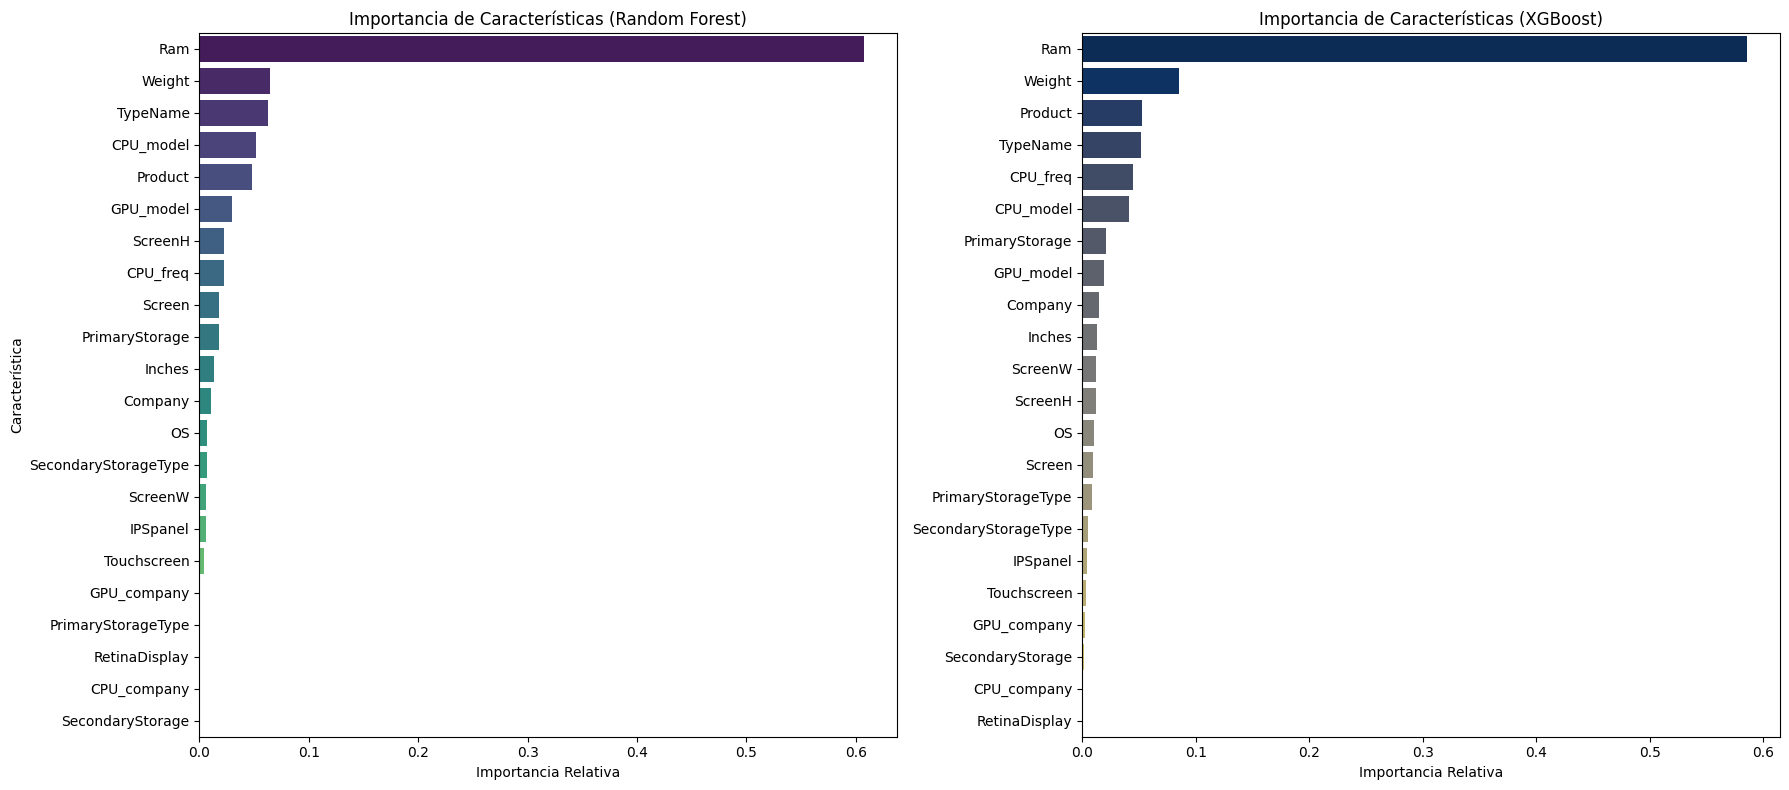

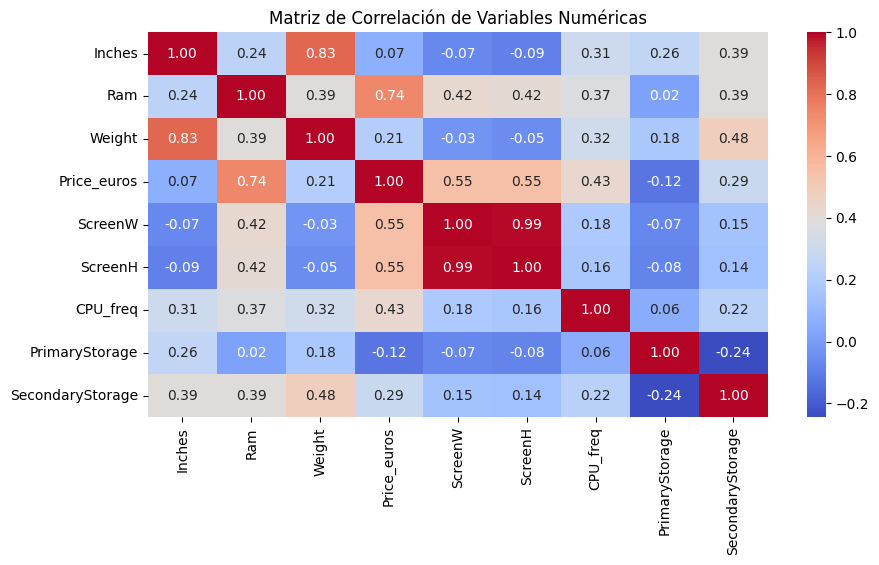

In [49]:
fi_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': train_models[1].feature_importances_
}).sort_values('Importance', ascending=False)

fi_xg = pd.DataFrame({
    'Feature': X.columns,
    'Importance': train_models[2].feature_importances_
}).sort_values('Importance', ascending=False)

# Configurar la figura y los subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8)) # 1 fila, 2 columnas

# --- Subplot 1: Random Forest Feature Importance ---
sns.barplot(x='Importance', y='Feature', data=fi_rf, palette='viridis', ax=axes[0])
axes[0].set_title('Importancia de Características (Random Forest)')
axes[0].set_xlabel('Importancia Relativa')
axes[0].set_ylabel('Característica')
axes[0].tick_params(axis='y', labelsize=10) # Ajusta tamaño de etiquetas para mejor lectura

# --- Subplot 2: XGBoost Feature Importance ---
sns.barplot(x='Importance', y='Feature', data=fi_xg, palette='cividis', ax=axes[1])
axes[1].set_title('Importancia de Características (XGBoost)')
axes[1].set_xlabel('Importancia Relativa')
axes[1].set_ylabel('') # Deja la etiqueta del eje Y vacía para evitar redundancia
axes[1].tick_params(axis='y', labelsize=10)

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()
plt.show()

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Matriz de Correlación de Variables Numéricas")
plt.show()

**Resumen Comparativo: Importancia de Features vs Matriz de Correlación**

El análisis comparativo revela coincidencias y discrepancias importantes entre la matriz de correlación y la importancia de features determinada por los modelos. La RAM emerge como el predictor más consistente, mostrando la correlación más fuerte con el precio (0.74) y manteniendo alta importancia en los modelos de Machine Learning. Las dimensiones de pantalla (ScreenW/ScreenH) también muestran coherencia, con correlación moderada (0.55) y alta importancia, aunque su casi perfecta correlación entre sí (0.99) sugiere posible redundancia. La frecuencia del CPU (CPU_freq) mantiene su posición como predictor secundario con correlación moderada (0.43) e importancia media-alta en los modelos.

Las discrepancias más notables aparecen en PrimaryStorage, que muestra una correlación negativa débil (-0.12) pero alta importancia en los modelos, indicando relaciones no lineales que la correlación lineal no captura. Esto sugiere que los modelos detectan patrones complejos como el tipo de almacenamiento (SSD vs HDD) o interacciones con otras variables. El tamaño en pulgadas (Inches) confirma su baja influencia directa en el precio (correlación 0.07), mientras que su fuerte correlación con el peso (0.83) explica su importancia indirecta en los modelos. 

Estas diferencias demuestran cómo los algoritmos de Machine Learning pueden identificar relaciones más sofisticadas que van más allá de las correlaciones lineales simples, proporcionando una visión más completa de los factores que determinan el precio de las laptops.

### 2.10 Optimización de Random Forest y XGBoost

Se prueba una versión simplificada del Random Forest y XGBoost eliminando características con muy baja importancia (< 0.0005). El objetivo es reducir la complejidad del modelo manteniendo el rendimiento.


In [50]:
alpha = 0.0005

In [51]:
rf_to_drop = fi_rf[fi_rf["Importance"] < alpha]["Feature"].tolist()
rf_to_drop

['PrimaryStorageType', 'RetinaDisplay', 'CPU_company', 'SecondaryStorage']

In [52]:
laptop_data_rf = laptop_data.drop(columns=rf_to_drop)

X_rf = laptop_data_rf.drop('Price_euros', axis=1)
y_rf = laptop_data_rf["Price_euros"]

X_train_val_rf, X_test_rf, y_train_val_rf, y_test_rf = train_test_split(X_rf, y_rf, train_size=0.9, random_state=42)

cv_rf = cross_val_score(rf, X_train_val_rf, y_train_val_rf, cv=kfold, scoring='neg_mean_absolute_error')
print(f"Random Forest (MAE):")
print(f"Mean CV Score: {-cv_rf.mean()}")
print(f"STD CV Score: {cv_rf.std()}")
print()


Random Forest (MAE):
Mean CV Score: 182.7629791238991
STD CV Score: 18.933988021568002



In [53]:
xg_to_drop = fi_xg[fi_xg["Importance"] < alpha]["Feature"].tolist()
xg_to_drop

['CPU_company', 'RetinaDisplay']

In [54]:
laptop_data_xg = laptop_data.drop(columns=xg_to_drop)

X_xg = laptop_data_xg.drop('Price_euros', axis=1)
y_xg = laptop_data_xg["Price_euros"]

X_train_val_xg, X_test_xg, y_train_val_xg, y_test_xg = train_test_split(X_xg, y_xg, train_size=0.9, random_state=42)

cv_xg = cross_val_score(xg, X_train_val_xg, y_train_val_xg, cv=kfold, scoring='neg_mean_absolute_error')
print(f"XGBoost (MAE):")
print(f"Mean CV Score: {-cv_xg.mean()}")
print(f"STD CV Score: {cv_xg.std()}")
print()

XGBoost (MAE):
Mean CV Score: 178.57220460534694
STD CV Score: 13.891994095670022



Comparativa: Original vs. Filtrado (Umbral < 0.005)

| Modelo | Cambio en MAE | Cambio en Estabilidad (STD) |
| --- | --- | --- |
| **Random Forest** | Empeora ( MAE 182.24 a **182.76** ) | Mejora ( STD 19.15 a 18.93) |
| **XGBoost** | Mejora (MAE 179.65 a **178.57** ) | Empeora ( STD 13.41 a 13.89) |


**Análisis de la Limpieza. ¿Valió la pena la eliminación?**



En **Random Forest**,  el error (MAE) **subió un poco** pero la desviación estándar bajó, lo que significa que el modelo es ligeramente más consistente ahora.

En **XGBoost**, el impacto fue justamente lo contrario: el error del MAE bajó pero la desviación estándar aumentó, lo que indica que esas variables "pequeñas" que se eliminaron le daban a XGBoost una pequeña estabilidad.


### 2.11 Análisis de Normalidad

Se realiza la prueba de Shapiro-Wilk para verificar si las diferencias entre los errores de los modelos siguen una distribución normal. Esto es importante para determinar qué pruebas estadísticas usar en la comparación de modelos.


In [55]:
from itertools import combinations

print("=== ANÁLISIS DE NORMALIDAD DE DIFERENCIAS (Shapiro-Wilk) ===")

# Generamos todas las combinaciones posibles de a 2 modelos
for (i, name_a), (j, name_b) in combinations(enumerate(model_names), 2):
    diff = cv_scores[i] - cv_scores[j]
    s_stat, p_value = shapiro(diff)
    
    status = "✅ Normal" if p_value > 0.05 else "❌ NO normal"
    print(f"{name_a} vs {name_b}: p={p_value:.4f} -> {status}")

=== ANÁLISIS DE NORMALIDAD DE DIFERENCIAS (Shapiro-Wilk) ===
Linear Regression vs Decision Tree: p=0.4489 -> ✅ Normal
Linear Regression vs Random Forest: p=0.8605 -> ✅ Normal
Linear Regression vs XGBoost: p=0.2061 -> ✅ Normal
Decision Tree vs Random Forest: p=0.0966 -> ✅ Normal
Decision Tree vs XGBoost: p=0.1489 -> ✅ Normal
Random Forest vs XGBoost: p=0.3816 -> ✅ Normal


**Resultado**

Todas las comparaciones muestran distribución normal (p > 0.05), lo que justifica el uso de pruebas paramétricas.

### 2.12 Comparación Estadística de Modelos

Se realizan pruebas t pareadas con corrección de Bonferroni para comparar estadísticamente los modelos. La corrección de Bonferroni ajusta el nivel de significancia para evitar falsos positivos en múltiples comparaciones.

In [56]:
import pandas as pd
from scipy import stats
from itertools import combinations

resultados = dict(zip(model_names, cv_scores))

# 2. Configuración
modelos = list(resultados.keys())
comparaciones = list(combinations(modelos, 2))
alpha = 0.05
alpha_bonferroni = alpha / len(comparaciones)

tabla_resultados = []

print("=== ANÁLISIS DEL T-TEST ===")


# 3. Cálculo de las Pruebas T
for mod1, mod2 in comparaciones:
    v1 = resultados[mod1]
    v2 = resultados[mod2]
    
    t_stat, p_val = stats.ttest_rel(v1, v2)
    m1, m2 = np.mean(v1), np.mean(v2)
    
    # Lógica para determinar el ganador
    es_significativo = p_val < alpha_bonferroni
    
    if es_significativo:
        ganador = mod1 if m1 < m2 else mod2
    else:
        ganador = "Empate técnico"

    tabla_resultados.append({
        'Comparación': f"{mod1} vs {mod2}",
        'Error Modelo 1': round(m1, 2),
        'Error Modelo 2': round(m2, 2),
        '   P-Value': f"{p_val:.6f}",
        '¿Significativo?': 'SÍ' if es_significativo else 'NO',
        'Mejor Modelo': ganador
    })

# 4. Mostrar resultados
df_final = pd.DataFrame(tabla_resultados)
print(f"Alpha: 0.05 ÷ 6 = {alpha_bonferroni:.4f}\n")
print(df_final.to_string(index=False))

=== ANÁLISIS DEL T-TEST ===
Alpha: 0.05 ÷ 6 = 0.0083

                       Comparación  Error Modelo 1  Error Modelo 2    P-Value ¿Significativo?   Mejor Modelo
Linear Regression vs Decision Tree          272.35          228.12   0.000378              SÍ  Decision Tree
Linear Regression vs Random Forest          272.35          182.24   0.000000              SÍ  Random Forest
      Linear Regression vs XGBoost          272.35          179.65   0.000000              SÍ        XGBoost
    Decision Tree vs Random Forest          228.12          182.24   0.000012              SÍ  Random Forest
          Decision Tree vs XGBoost          228.12          179.65   0.000027              SÍ        XGBoost
          Random Forest vs XGBoost          182.24          179.65   0.603174              NO Empate técnico


Tras realizar las pruebas de hipótesis con la **corrección de Bonferroni** (un método muy riguroso), podemos concluir lo siguiente:

1. **XGBoost y Random Forest son los líderes:** Ambos modelos son significativamente mejores que la Regresión Lineal y el Árbol de Decisión.
2. **Superioridad Estadística:** No hay una diferencia estadísticamente significativa entre Random Forest y XGBoost. Esto significa que, con los datos actuales, ambos tienen el mismo desempeño real.


### 2.13 Conclusiones y Elección Final

Aunque hay un **empate técnico** entre **Random Forest** y **XGBoost**, elegiríamos **XGBoost**. ¿Por qué? Porque en el análisis de Validación Cruzada anterior, XGBoost mostró una **desviación estándar menor (13.41)**, lo que lo hace más estable y confiable. 

In [57]:
print("=== Test final para XGBoost entrenado con los conjuntos de entrenamiento y validación juntos === ")
xg_model = xg.fit(X_train_val, y_train_val)
y_predict = xg_model.predict(X_test)
evaluate(y_test, y_predict)

=== Test final para XGBoost entrenado con los conjuntos de entrenamiento y validación juntos === 
MSE: 53785.94
RMSE: 231.92
R2: 0.8942
MAE: 155.44
MAPE: 0.1455 (14.55%)



**El modelo XGBoost desarrollado permite predecir el precio de una laptop con un error promedio de $155 USD (MAE) y una variación porcentual del 14.5%. Dado que la RAM explica el 58% de la variancia del precio, se recomienda a los departamentos de compras priorizar el análisis de costos de este componente para mantener márgenes competitivos.**